<a href="https://colab.research.google.com/github/sebaspv/WaifuNet/blob/main/WaifuNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import numpy as np

import urllib.request
import zipfile
from IPython import display

In [2]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [3]:
import os
try:
  os.mkdir('/tmp/anime')
except OSError:
  pass

# download the zipped dataset to the data directory
data_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Resources/anime-faces.zip"
data_file_name = "animefaces.zip"
download_dir = '/tmp/anime/'
urllib.request.urlretrieve(data_url, data_file_name)

# extract the zip file
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [4]:
IMAGE_SIZE = 64
BATCH_SIZE = 32

In [5]:
def get_dataset_slice_paths(image_dir):
  '''returns a list of paths to the image files'''
  image_file_list = os.listdir(image_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

  return image_paths


def map_image(image_filename):
  '''preprocesses the images'''
  img_raw = tf.io.read_file(image_filename)
  image = tf.image.decode_jpeg(img_raw)

  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = image / 255.0  
  image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3,))

  return image

In [6]:
paths = get_dataset_slice_paths("/tmp/anime/images/")
import random
random.shuffle(paths)

In [7]:
training_dataset = tf.data.Dataset.from_tensor_slices((paths))
training_dataset = training_dataset.map(map_image).batch(BATCH_SIZE)

In [8]:
training_dataset

<BatchDataset shapes: (None, 64, 64, 3), types: tf.float32>

In [9]:
len(training_dataset)

1987

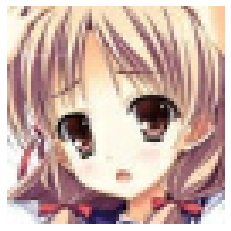

In [10]:
plt.axis(False)
for i in training_dataset:
  plt.imshow(np.array(i[0]))
  break
# we have succesfully preprocessed and resized the dataset

In [66]:
# create the generator model
random_dimensions = 32
generator = keras.models.Sequential()
generator.add(keras.layers.Dense(512*4*4, input_shape = [random_dimensions]))
generator.add(keras.layers.Reshape([4, 4, 512]))
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.Conv2DTranspose(filters = 128, kernel_size = 5, strides = 2, padding = 'same', activation = 'selu')) #8*8*128
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.Conv2DTranspose(64, kernel_size = 5, strides = 2, padding = 'same', activation = 'selu')) #16*16*64
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.Conv2DTranspose(32, kernel_size = 5, strides = 2, padding = 'same', activation = 'selu')) #32*32*32
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.Conv2DTranspose(3, kernel_size = 5, strides = 2, padding = 'same', activation = 'tanh')) # 64*64*3

In [67]:
generator.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 8192)              270336    
_________________________________________________________________
reshape_8 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 4, 4, 512)         2048      
_________________________________________________________________
conv2d_transpose_32 (Conv2DT (None, 8, 8, 128)         1638528   
_________________________________________________________________
batch_normalization_33 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 16, 16, 64)        204864    
_________________________________________________________________
batch_normalization_34 (Batc (None, 16, 16, 64)      

In [68]:
discriminator = keras.models.Sequential()
discriminator.add(keras.layers.Conv2D(16, 5, 2, padding = 'same', input_shape = [64, 64, 3])) # 32*32*16
discriminator.add(keras.layers.LeakyReLU(alpha = 0.2))
discriminator.add(keras.layers.Conv2D(32, 5, 2, padding = 'same')) # 16*16*32
discriminator.add(keras.layers.LeakyReLU(alpha = 0.2))
discriminator.add(keras.layers.Conv2D(64, 5, 2, padding = 'same')) # 8*8*64
discriminator.add(keras.layers.LeakyReLU(alpha = 0.2))
discriminator.add(keras.layers.Conv2D(128, 5, 2, padding = 'same')) # 4*4*128
discriminator.add(keras.layers.LeakyReLU(alpha = 0.2))
discriminator.add(keras.layers.Flatten())
discriminator.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [69]:
discriminator.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 32, 32, 16)        1216      
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 32)        12832     
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 4, 4, 128)       

In [70]:
# compile the discriminator and freeze
#discriminator.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0002), loss = 'binary_crossentropy')
discriminator.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')
discriminator.trainable = False

In [71]:
gan = keras.models.Sequential([generator, discriminator])
#gan.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 0.0002))
gan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

In [72]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            real_batch_size = real_images.shape[0]
            # random noise
            noise = tf.random.normal(shape = [real_batch_size, random_normal_dimensions])
            # Use the noise to generate fake images
            fake_images = generator(noise)
            mixed_images = tf.concat([fake_images, real_images], axis = 0)
            discriminator_labels = tf.constant([[0.]]*real_batch_size + [[1.]]*real_batch_size)
            # Ensure that the discriminator is trainable
            discriminator.trainable = True
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            # PHASE 2 OF TRAINING
            noise = tf.random.normal([real_batch_size, random_normal_dimensions])
            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]]*real_batch_size)
            # Freeze the discriminator
            discriminator.trainable = False
            # Train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
        plot_results(fake_images, 16)                     
        plt.show()
    return fake_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

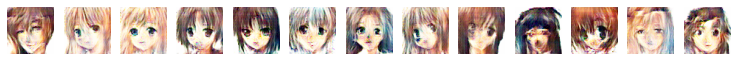

In [73]:
# you can adjust the number of epochs
EPOCHS = 5

# run the training loop and collect images
fake_images = train_gan(gan, training_dataset, random_dimensions, EPOCHS)